In [144]:
import os
from PIL import Image
import json

In [3]:
data_path = r"/home/alex/data/nlp/agmir"
img_path = os.path.join(data_path, r"img")
captions_path = os.path.join(data_path, r"txt/ecgen-radiology")

In [81]:
imgs = os.listdir(img_path)
captions = os.listdir(captions_path)
print(len(imgs), len(captions))

7471 3955


### test loading one image

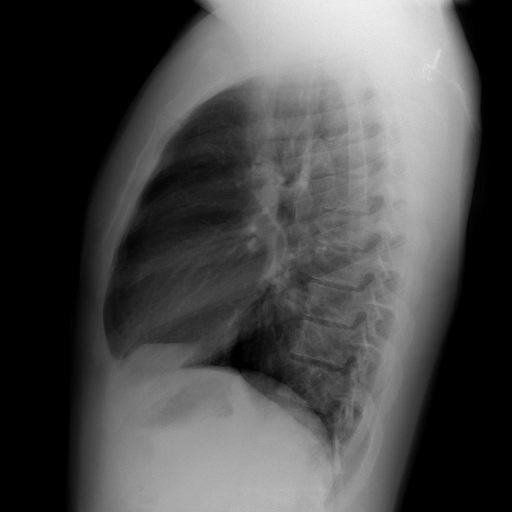

In [8]:
Image.open(os.path.join(img_path,imgs[0]))

### parse captions

In [30]:
import xml.etree.ElementTree as ET

In [109]:
%%time
cases = []
for case in captions[:]:
    xml_data = os.path.join(captions_path, case)
    etree = ET.parse(xml_data) #create an ElementTree object 
    eroot = etree.getroot()
    case_data = {}
    case_data['id'] = eroot.findall("uId")[0].get("id")
    text_nodes = eroot.findall("MedlineCitation")[0].findall("Article")[0].findall("Abstract")[0].findall("AbstractText")
    for node in text_nodes:
        case_data[node.get("Label").lower()] = node.text
    case_data['tags_manual'] = [t.text for t in eroot.findall("MeSH")[0].findall("major")]
    case_data['tags_mti'] = [t.text for t in eroot.findall("MeSH")[0].findall("automatic")]
    cases.append(case_data)

CPU times: user 772 ms, sys: 48 ms, total: 820 ms
Wall time: 819 ms


### map w/ images

In [110]:
%%time
for case in cases:
    case['images'] = [img for img in imgs if case['id']+"_" in img]

CPU times: user 3.46 s, sys: 24 ms, total: 3.49 s
Wall time: 3.49 s


In [111]:
count = 0
for case in cases:
    if len(case['images']) > 0:
        count += 1
print(count, len(cases))

3851 3955


In [146]:
cases

[{'id': 'CXR2216',
  'comparison': 'None',
  'indication': 'XXXX with low-grade XXXX and midback pain x2 weeks.',
  'findings': 'Heart size and mediastinal contours are within normal limits. Pulmonary vasculature is unremarkable. No focal airspace consolidation. There is mild elevation right hemidiaphragm. No visible pleural effusion or pneumothorax. There are mild degenerative changes along the thoracic spine.',
  'impression': '1. Mildly elevated right hemidiaphragm. Otherwise no acute cardiopulmonary abnormality seen.',
  'tags_manual': ['Diaphragm/right/elevated/mild',
   'Thoracic Vertebrae/degenerative/mild'],
  'tags_mti': ['degenerative change', 'Diaphragm'],
  'images': ['CXR2216_IM-0821-85075001.png', 'CXR2216_IM-0821-85075002.png']},
 {'id': 'CXR4',
  'comparison': 'None available',
  'indication': 'XXXX-year-old XXXX with XXXX.',
  'findings': 'There are diffuse bilateral interstitial and alveolar opacities consistent with chronic obstructive lung disease and bullous emphys

In [147]:
with open(os.path.join(data_path,'cases.json'),'w') as handle:
    json.dump(cases, handle)

### check tags

In [128]:
tags = []
for case in cases:
    tags += case['tags_mti']
tags_voc = list(set(tags))

In [129]:
len(tags), len(tags_voc)

(7047, 659)

In [139]:
tags_voc = [t.lower() for t in tags_voc]

In [140]:
len(set(tags_voc))

586

### further process tags

In [126]:
from sklearn.feature_extraction.text import CountVectorizer

In [127]:
countvec = CountVectorizer()

In [132]:
countvec.fit_transform(tags_voc)

<659x517 sparse matrix of type '<class 'numpy.int64'>'
	with 1201 stored elements in Compressed Sparse Row format>

In [136]:
len(countvec.vocabulary_)

517

In [141]:
len(countvec.vocabulary_)

517